# SETUP

In [ ]:
!pip install decord
!pip install transformers ftfy regex tqdm
!pip install timm
!pip install av
!pip install ffmpeg-python

In [ ]:
# Standard
import os
import sys
import json

# Scientific calculus and data anilisys
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

# DeepL
import torch
import torch.nn as nn
from transformers import AutoTokenizer, CLIPTokenizer, CLIPModel

# Grapgics and visualization
from tqdm import tqdm # Barra di caricamento
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("Drive mounted")

REPO_PATH = '/content/drive/MyDrive/AML_Project/3_EgoVLP/EgoVLP-main'

if REPO_PATH not in sys.path:
    sys.path.append(REPO_PATH)

try:
    from model.model import FrozenInTime
    print("EgoVLP module successfully imported from the repository")
except ImportError as e:
    print(f"Error during import: {e}")
    print("Ensure that REPO_PATH points to the folder containing \"model\", \"utils\", etc.")

Mounted at /content/drive
Drive mounted
EgoVLP module successfully imported from the repository


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {DEVICE}")

Running on: cpu


# TEXT FEATURE EXTRACTION (EgoVLP)

In [ ]:
%cd /content/drive/MyDrive/AML_Project/3_EgoVLP/
# --- LOADING MODEL ---

# Standard configuration for EgoVLP (based on configs/eval/epic.json)
# These parameters match those used during pre-training of the checkpoint
config = {
    "video_params": {
        "model": "SpaceTimeTransformer",
        "arch_config": "base_patch16_224",
        "num_frames": 16,
        "pretrained": True,
        "time_init": "zeros"
    },
    "text_params": {
        "model": "distilbert-base-uncased", # EgoVLP backend
        "pretrained": True,
        "input": "text"
    },
    "projection_dim": 256,
    "load_checkpoint": None # We upload it manually
}

print("Creating EgoVLP model...")
model = FrozenInTime(
    video_params=config['video_params'],
    text_params=config['text_params'],
    projection_dim=config['projection_dim'],
    load_checkpoint=None
)

# Loading Weights
checkpoint_path = '/content/drive/MyDrive/AML_Project/3_EgoVLP/checkpoints/egovlp.pth'

if os.path.exists(checkpoint_path):
    print(f"Loading weights from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

    # Load, ignoring warnings if video keys are missing cause we are using text
    # strict=False is useful if the checkpoint has extra modules that are not currently used
    msg = model.load_state_dict(state_dict, strict=False)
    print(f"Loading result: {msg}")
else:
    print("ERROR: Checkpoint not found! Check the path")

model = model.to(DEVICE)
model.eval()

# Initialise Tokeniser (required to transform strings into input for the model)
# EgoVLP uses the tokeniser associated with the text model (e.g. DistilBert)
tokenizer = AutoTokenizer.from_pretrained(config['text_params']['model'])
print("Model and Tokenizer ready")

/content/drive/.shortcut-targets-by-id/1vxgD6uYnr2LpQalDA9eOLzCE7O5v_LHt/AML_Project/3_EgoVLP
Creating EgoVLP model...
######USING ATTENTION STYLE:  frozen-in-time
Loading weights from /content/drive/MyDrive/AML_Project/3_EgoVLP/checkpoints/egovlp.pth...
Loading result: _IncompatibleKeys(missing_keys=['text_model.embeddings.word_embeddings.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.LayerNorm.bias', 'text_model.transformer.layer.0.attention.q_lin.weight', 'text_model.transformer.layer.0.attention.q_lin.bias', 'text_model.transformer.layer.0.attention.k_lin.weight', 'text_model.transformer.layer.0.attention.k_lin.bias', 'text_model.transformer.layer.0.attention.v_lin.weight', 'text_model.transformer.layer.0.attention.v_lin.bias', 'text_model.transformer.layer.0.attention.out_lin.weight', 'text_model.transformer.layer.0.attention.out_lin.bias', 'text_model.transformer.layer.0.sa_layer_norm.weight', 'text_mo

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model and Tokenizer ready


In [ ]:
def parse_recipe_graph(json_path):
    """
    Reads the JSON and extracts the sorted texts.
    Manages the numerical sorting of the keys (1, 2, ..., 10).
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    # JSON has the following structure: {"steps": {"1": "...", "2": "..."}}
    steps_dict = data['steps']

    # We order the keys as integers (essential to avoid having 1, 10, 2, etc.).
    sorted_keys = sorted([int(k) for k in steps_dict.keys()])

    text_nodes = []

    for k in sorted_keys:
        raw_text = steps_dict[str(k)]

        # Text cleaning
        clean_text = raw_text.replace("-", " ")

        text_nodes.append(clean_text)

    return text_nodes

def encode_text_egovlp(text_list, model, tokenizer, device):
    """
    Generate embeddings for a list of texts using EgoVLP.
    Use the model's “compute_text” method directly to avoid errors.
    """
    model.eval()

    # 1. Tokenisation
    inputs = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=77, # max_length=77 is the standard for these models
        return_tensors="pt"
    )

    # moving input dictionary to the device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 2. Forward pass
    with torch.no_grad():
        text_embeds = model.compute_text(inputs) # extracts DistilBERT output and applies txt_proj

    return text_embeds



In [ ]:
input_folder = '/content/drive/MyDrive/AML_Project/annotations-main/task_graphs'
output_folder = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/text_features_egovlp'

# create output folder
os.makedirs(output_folder, exist_ok=True)

print(f"Reading graphs from: {input_folder}")
print(f"Saving features in: {output_folder}")

# Obtaining the list of all JSON files
json_files = [f for f in os.listdir(input_folder) if f.endswith('.json')]

print(f"Found {len(json_files)} receipts to elaborate")

model.eval() # make sure the model is in eval mode.

for json_file in tqdm(json_files, desc="Text Feature Extraction"):
    try:
        # 1. Build the full path
        full_input_path = os.path.join(input_folder, json_file)

        # 2. Extract text (parsing)
        steps_text = parse_recipe_graph(full_input_path)

        if not steps_text:
            print(f"Warning: No steps found in {json_file}")
            continue

        # 3. Extract embeddings (inference)
        embeddings = encode_text_egovlp(steps_text, model, tokenizer, DEVICE)

        # 4. Save to Drive
        # Save as a dictionary to retain the original text (useful for debugging)
        save_data = {
            "text_features": embeddings.cpu(), # Move to CPU for saving
            "raw_text": steps_text,
            "recipe_id": json_file.replace(".json", "")
        }

        output_filename = json_file.replace('.json', '.pt')
        full_output_path = os.path.join(output_folder, output_filename)

        torch.save(save_data, full_output_path)

    except Exception as e:
        print(f"ERROR processing {json_file}: {e}")

print("\n--- Processing completed ---")
print(f"The text features have been saved in: {output_folder}")

Leggendo i grafi da: /content/drive/MyDrive/AML_Project/annotations-main/task_graphs
Salvando le feature in: /content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/text_features_egovlp_test
Trovate 24 ricette da elaborare.


Estrazione Feature Testuali: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


--- Elaborazione Completata ---
Le feature testuali sono state salvate in: /content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/text_features_egovlp_test


# MATCHING

In [ ]:
# --- PATH CONFIGURATION ---
VIDEO_FEATS_DIR = '/content/drive/MyDrive/AML_Project/Extension/step1_HiERO/steps_v4'
TEXT_FEATS_DIR = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/text_features_egovlp'
OUTPUT_MATCH_DIR = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/matched_features_v2'
ANNOTATIONS_PATH = '/content/drive/MyDrive/AML_Project/annotations-main/annotation_json/complete_step_annotations.json'

os.makedirs(OUTPUT_MATCH_DIR, exist_ok=True)

# --- METADATA LOADING ---
print("Loading Annotations...")
with open(ANNOTATIONS_PATH, 'r') as f:
    ann_data = json.load(f)
video_to_recipe = {k: v['activity_name'] for k, v in ann_data.items() if 'activity_name' in v}

# --- FLEXIBILITY PARAMETER ---
# lambda_order only penalizes early occurrences.
# If set to 1.0, it almost entirely prevents a step from appearing before its logical time,
# but it doesn't penalize if the step appears later (allowing for pauses or background tasks at the start).
lambda_order = 1.0

video_files = [f for f in os.listdir(VIDEO_FEATS_DIR) if f.endswith('.npz')]
print(f"Starting flexible matching on {len(video_files)} files...")

success_count = 0

for v_file in tqdm(video_files):
    try:
        vid_id = v_file.replace("_steps.npz", "")
        if vid_id not in video_to_recipe: continue
        recipe_name = video_to_recipe[vid_id]

        # 1. Video Features Loading (HiERO)
        v_path = os.path.join(VIDEO_FEATS_DIR, v_file)
        v_np = np.load(v_path)
        v_feats_np = v_np['embeddings'] if 'embeddings' in v_np else v_np['arr_0']
        v_feats = torch.from_numpy(v_feats_np).float()

        # 2. Text Features Loading (EgoVLP)
        t_file = recipe_name.lower().replace(" ", "").replace("-", "") + ".pt"
        t_path = os.path.join(TEXT_FEATS_DIR, t_file)
        if not os.path.exists(t_path): continue
        t_data = torch.load(t_path, weights_only=False)
        t_feats = t_data['text_features'].float()

        # 3. Cost Matrix Preparation
        v_norm = torch.nn.functional.normalize(v_feats, p=2, dim=1).cpu().numpy()
        t_norm = torch.nn.functional.normalize(t_feats, p=2, dim=1).cpu().numpy()

        # Pure semantic distance (1 - Cosine Similarity)
        cost_matrix = cdist(v_norm, t_norm, metric='cosine')

        # 4. ORDER PENALTY LOGIC (NOT DIAGONAL)
        M, N = cost_matrix.shape
        for i in range(M): # Video Time
            for j in range(N): # Recipe Progression
                rel_v = i / M # Relative position in video (0.0 - 1.0)
                rel_t = j / N # Relative position in recipe (0.0 - 1.0)

                # If the step (rel_t) tries to appear too early in the video (rel_v),
                # we apply a quadratic penalty.
                # If it appears later (rel_v > rel_t), we apply no penalty (delay is ok).
                if rel_v < (rel_t - 0.15): # 15% tolerance to compensate for long segments
                    diff = (rel_t - rel_v)
                    cost_matrix[i, j] += lambda_order * (diff ** 2)

        # 5. Hungarian Matching
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        matches = list(zip(row_ind, col_ind))

        # 6. Saving
        torch.save({
            "video_id": vid_id, "recipe_id": recipe_name,
            "video_features": v_feats, "text_features": t_feats,
            "matches": matches, "cost_matrix": cost_matrix
        }, os.path.join(OUTPUT_MATCH_DIR, f"match_{vid_id}.pt"))

        success_count += 1

    except Exception:
        continue

print(f"\n--- END ---")
print(f"Successfully saved: {success_count} matches")

Caricamento Annotazioni...
Inizio matching flessibile su 384 file...


100%|██████████| 384/384 [00:29<00:00, 13.02it/s]


--- FINE ---
Salvati correttamente: 384 match.


# GNN FEATS GEN

In [ ]:
# --- PATH CONFIGURATION ---
MATCH_FILES_DIR = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/matched_features_v2'
TASK_GRAPHS_DIR = '/content/drive/MyDrive/AML_Project/annotations-main/task_graphs'
ERROR_ANN_PATH = '/content/drive/MyDrive/AML_Project/annotations-main/annotation_json/error_annotations.json'
OUTPUT_GNN_DATA_DIR = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/gnn_ready_data'

os.makedirs(OUTPUT_GNN_DATA_DIR, exist_ok=True)

# 1. Load Ground Truth Labels (is_error)
with open(ERROR_ANN_PATH, 'r') as f:
    error_data = json.load(f)
error_map = {item['recording_id']: item['is_error'] for item in error_data}

def extract_real_task_edges(json_path):
    """Extracts the non-linear structure from the original Task Graph JSON."""
    if not os.path.exists(json_path): return [], 0
    with open(json_path, 'r') as f:
        data = json.load(f)

    steps_dict = data.get('steps', {})
    sorted_ids = sorted([int(k) for k in steps_dict.keys()])
    id_to_idx = {str(sid): i for i, sid in enumerate(sorted_ids)}

    raw_edges = []
    # Look for edges in Captain Cook4D format
    for key in ['edges', 'adjacency', 'successors']:
        if key in data and data[key]:
            if isinstance(data[key], list):
                raw_edges = data[key]
            elif isinstance(data[key], dict):
                for u, neighbors in data[key].items():
                    for v in neighbors: raw_edges.append([u, v])
            break

    final_edges = []
    for edge in raw_edges:
        u, v = str(edge[0]), str(edge[1])
        if u in id_to_idx and v in id_to_idx:
            final_edges.append([id_to_idx[u], id_to_idx[v]])

    return final_edges, len(id_to_idx)

# --- GENERATION LOOP ---
match_files = [f for f in os.listdir(MATCH_FILES_DIR) if f.endswith('.pt')]
print(f"Generating {len(match_files)} structured graphs...")

success_count = 0
for m_file in tqdm(match_files):
    # Loading matches from Step 3
    m_data = torch.load(os.path.join(MATCH_FILES_DIR, m_file), weights_only=False)

    vid_id = m_data.get('video_id', 'unknown')
    recipe_name = m_data.get('recipe_id', 'unknown')

    # 1. Retrieve Real Task Graph Structure
    target_json = recipe_name.lower().replace(" ", "").replace("-", "") + ".json"
    json_path = os.path.join(TASK_GRAPHS_DIR, target_json)

    # Flexible search for the JSON file
    if not os.path.exists(json_path):
        for f in os.listdir(TASK_GRAPHS_DIR):
            if f.lower().replace(" ", "").replace("-", "") == target_json:
                json_path = os.path.join(TASK_GRAPHS_DIR, f)
                break

    edges, _ = extract_real_task_edges(json_path)

    # 2. Align Video Features to Nodes
    x_t = m_data['text_features']
    x_v = m_data['video_features']
    num_nodes = x_t.shape[0]

    # Aligned matrix: assign each step (text) its corresponding video match
    aligned_video_feats = torch.zeros_like(x_t)
    for v_idx, t_idx in m_data['matches']:
        if int(t_idx) < num_nodes and int(v_idx) < x_v.shape[0]:
            aligned_video_feats[int(t_idx)] = x_v[int(v_idx)]

    # 3. Correct Label from error_annotations.json
    is_err = 1 if error_map.get(vid_id, False) else 0

    # 4. Save Complete GNN Object
    payload = {
        "vid_id": vid_id,
        "recipe": recipe_name,
        "x_text": x_t,
        "x_video": aligned_video_feats,
        "edge_index": torch.tensor(edges).t().long() if edges else torch.empty((2, 0)).long(),
        "y": torch.tensor(is_err, dtype=torch.float) # BCEWithLogitsLoss requires float or long depending on setup
    }

    torch.save(payload, os.path.join(OUTPUT_GNN_DATA_DIR, f"gnn_ready_{vid_id}.pt"))
    success_count += 1

print(f"\nDataset ready! Created {success_count} structured graphs with ground truth labels")

🔄 Generazione di 384 grafi strutturati...


100%|██████████| 384/384 [00:13<00:00, 27.81it/s]


✅ Dataset pronto! Creati 384 grafi strutturati con label reali.


# DATA VALIDATION

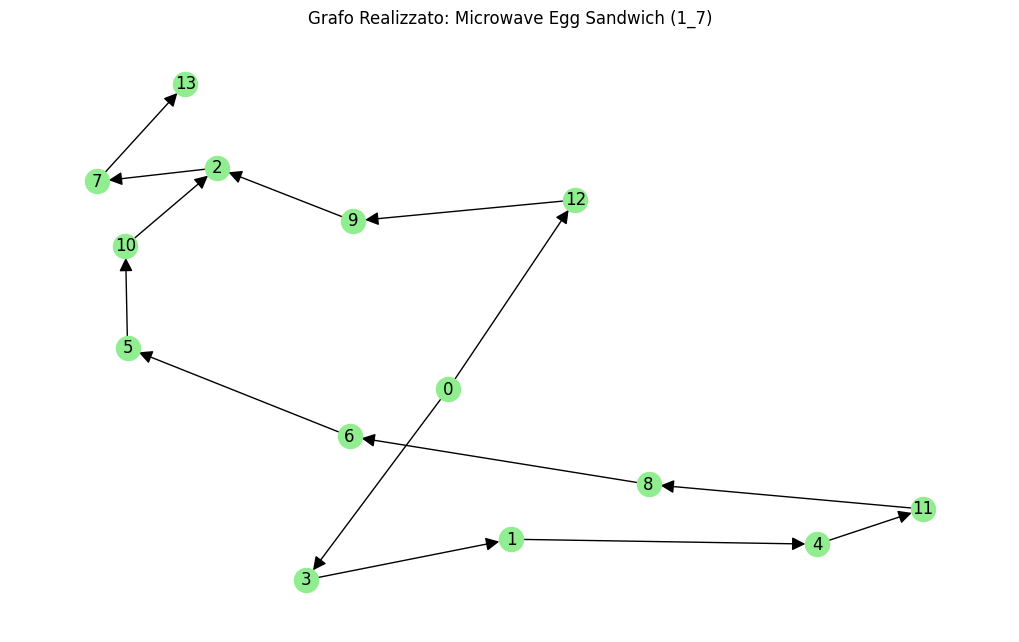

✅ Grafo costruito con 14 archi.


In [ ]:
FILE_DA_VEDERE = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/gnn_ready_data/gnn_ready_1_7.pt'

data = torch.load(FILE_DA_VEDERE)
edges = data['edge_index']

if edges.numel() == 0:
    print("Error: Edges are empty!")
else:
    G = nx.DiGraph()
    # Transform the [2, E] format into a list of tuples (u, v)
    edge_list = edges.t().tolist()
    G.add_edges_from(edge_list)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', arrowsize=20)
    plt.title(f"Generated Graph: {data['recipe']} ({data['vid_id']})")
    plt.show()
    print(f"Graph built with {len(edge_list)} edges")

In [ ]:
VIDEO_ID = "1_7"
HIERO_DIR = '/content/drive/MyDrive/AML_Project/Extension/step1_HiERO/steps_v4'
MATCH_DIR = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/matched_features_v2'
TASK_GRAPHS_DIR = '/content/drive/MyDrive/AML_Project/annotations-main/task_graphs'

# 1. Load the matches
match_data = torch.load(os.path.join(MATCH_DIR, f"match_{VIDEO_ID}.pt"), weights_only=False)
recipe_name = match_data['recipe_id']

# 2. Load the specific recipe JSON
target_json = recipe_name.lower().replace(" ", "").replace("-", "") + ".json"
json_path = os.path.join(TASK_GRAPHS_DIR, target_json)

# Flexible search for the JSON file (handles case sensitivity)
if not os.path.exists(json_path):
    for f in os.listdir(TASK_GRAPHS_DIR):
        if f.lower().replace(" ", "").replace("-", "") == target_json:
            json_path = os.path.join(TASK_GRAPHS_DIR, f)
            break

with open(json_path, 'r') as f:
    recipe_json = json.load(f)

# Create a dictionary mapping the step ID to its text
id_to_text = {int(k): v for k, v in recipe_json['steps'].items()}

# 3. Load the video segments
hiero_data = np.load(os.path.join(HIERO_DIR, f"{VIDEO_ID}_steps.npz"))
hiero_segments = hiero_data['segments']

# 4. Sort matches by video time
matches = sorted(match_data['matches'], key=lambda x: x[0])

print(f"--- CHRONOLOGICAL VERIFICATION FOR VIDEO {VIDEO_ID} ({recipe_name}) ---")
print(f"{'VIDEO SEGMENT (sec)':<25} | {'RECIPE STEP'}")
print("-" * 80)

for v_idx, t_idx in matches:
    start, end = hiero_segments[int(v_idx)]
    step_desc = id_to_text.get(int(t_idx), "Description not found")
    print(f"{start:7.2f}s - {end:7.2f}s           | Step {int(t_idx):>2}: {step_desc[:50]}...")

--- VERIFICA CRONOLOGICA VIDEO 1_7 (Microwave Egg Sandwich) ---
SEGMENTO VIDEO (sec)      | STEP RICETTA
--------------------------------------------------------------------------------
   0.00s -    8.53s           | Step  0: START...
   8.53s -   23.47s           | Step  1: Pour-Pour 1 egg into the ramekin cup...
  42.67s -   46.93s           | Step  3: Coat -Coat a 6-oz. ramekin cup with cooking spray...
  61.87s -   74.67s           | Step  5: sprinkle -sprinkle 1 tablespoon of cheese on cup...
  87.47s -  100.27s           | Step  6: Top -Top cup with 1 tablespoon of salsa...
 121.60s -  132.27s           | Step  2: Place -Place the egg from the cup over the lettuce...
 132.27s -  140.80s           | Step  4: Microwave-Microwave the ramekin cup uncovered on h...
 140.80s -  166.40s           | Step  8: Microwave -Continue to Microwave for 15-30 more se...
 174.93s -  185.60s           | Step  9: Line -Line the bottom piece of the English muffin ...
 192.00s -  198.40s           | 